## Classical SDP relaxation of OPF
As a first step, we present a simple implementation of the classical SDP formulation of the Optimnal Power Flow problem using CVXPY.

### Setup
We start by importing pandapower for the test cases;
CVXPY, an open source Python-embedded modeling language for convex optimization problems;
MOSEK, a large scale optimization software. 

In [1]:
import pandapower.networks as nw
import pandapower as pp
import pandas as pd
import numpy as np
import cvxpy as cp
from scipy.sparse import csr_matrix
import mosek
import plotly.express as px
import pandapower.plotting as plot

### Load Network Data
Now,let's make a function that loads the IEEE test cases from Pandapower.

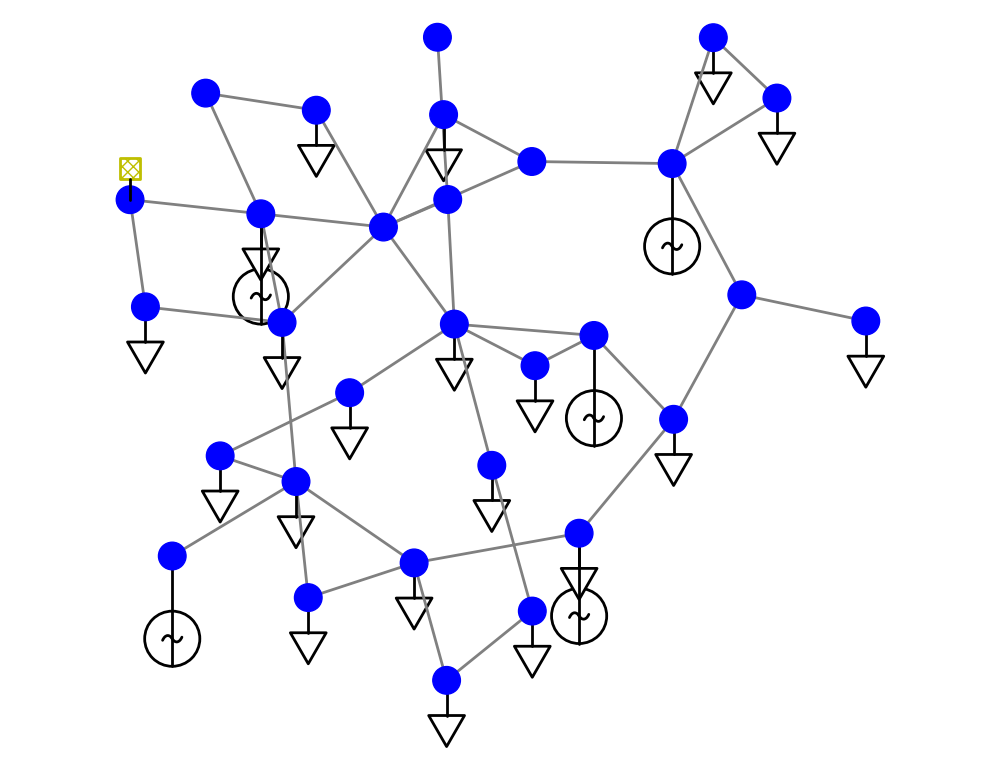

<Axes: >

In [3]:
# Select IEEE test case
def load_network(case):
    if case == 5:
        return nw.case5()
    if case == 14:
        return nw.case14()
    elif case == 30:
        return nw.case30()
    elif case == 57:
        return nw.case57()
    elif case == 118:
        return nw.case118()
    elif case == 300:
        return nw.case300()
    elif case == 'GB':
        return nw.GBnetwork()
    else:
        raise ValueError("Unsupported test case")
    
# Load the chosen IEEE test case
case_number = 30 # Change to 30, 57, or 118 for larger cases
net = load_network(case_number)

pp.runpp(net)  # Run power flow to initialize values
plot.simple_plot(net, show_plot=True, plot_loads=True, plot_gens=True, gen_size =4, load_size=3, line_width=2, bus_size=2)

When a power flow is carried out, the element based grid model is translated into a bus-branch model. That bus-branch model is stored in a data structure that is based on the PYPOWER/MATPOWER casefile (with some extensions). This ppc can be accessed after power flow using net._ppc
We will get the bus admittance matrix using exactly that and extract all the parameters we need.

In [9]:

#make sure all units are consistent (convert everything to per unit)
Sbase = net.sn_mva # unit value for power MVA
Vbase = min(net.bus.vn_kv) # unit value for voltage kV
Zbase = Vbase**2 / Sbase # base impedance in Ohms
Ybase = 1 / Zbase # base admittance in S

#Now, we extract network parameters
Ybus = net._ppc["internal"]["Ybus"].todense() # Bus admittance matrix (Already in per unit. We need todense since the matrices are stored as sparcse matrices, but dense are easier to work with)
n = len(net.bus)  # Number of buses

#we need line information to add line flow constraints
# Extract line connections as (from_bus, to_bus) tuples
lines = list(zip(net.line['from_bus'].astype(int), net.line['to_bus'].astype(int)))

#################### series admittance ##########################

y_lines = {}
for idx, row in net.line.iterrows():
    l = int(row['from_bus'])
    m = int(row['to_bus'])
    y_lines[(l,m)]= -Ybus[l, m]


#y_lines = np.zeros((n, n), dtype=complex) ## Initialize series admittance dictionary (n x n) with all zeros

## just use a list of lines that actually exist
#for l in range(n):
    #for m in range(n):
        #if l != m:
            #y_lines[l, m] = -Ybus[l, m]

###################### shunt admittance ######################

# Note c_nf_per_km (float) - line capacitance in nano Farad per km
y_shunt = {}
f = 50  # System frequency (Hz); change to 60 if using US grid
omega = 2 * np.pi * f  # Angular frequency (rad/s)

for idx, row in net.line.iterrows():
    l = int(row['from_bus'])
    m = int(row['to_bus'])
    C_per_km = row['c_nf_per_km']  # Capacitance in nF/km
    length = row['length_km']      # Line length in km
    C_total = C_per_km * 1e-9 * length  # Total capacitance (F)
    B_total = omega * C_total      # Total susceptance (S)
    y_shunt_lm = 1j * B_total / 2  # Half at each end (π-model)
    y_shunt_pu = y_shunt_lm/Ybase
    y_shunt[(l,m)]=y_shunt_pu
    
#y_shunt = np.zeros((n, n), dtype=complex)
#for k in range(n):
        #y_shunt[k, k] = 1/2 * (Ybus[k, k] + sum(Ybus[k, m] for m in range(n) if m != k))

##################### Double check s_max ####################################

# Define s_max for each line using max_i_ka and Vbase
s_max = {}
p_max = {}
max_v_diff_lm = {}
for idx, row in net.line.iterrows():
    l = int(row['from_bus'])
    m = int(row['to_bus'])
    Imax = row['max_i_ka']  # in kA   # IS This phase current or line current? #################################
    # Smax in MVA
    s_max[(l, m)] = np.sqrt(3) * Vbase * Imax  
    # Since we don't have info on P^max_lm, we will assume it is 95% of S^max_lm.
    p_max[(l, m)] = 0.95 * s_max[(l, m)]
    # Since we don't have the maximum voltage difference across a line, we will estimate it
    v_max_l = net.bus.loc[l, "max_vm_pu"]
    v_min_m = net.bus.loc[m, "min_vm_pu"]
    v_max_m = net.bus.loc[m, "max_vm_pu"]
    v_min_l = net.bus.loc[l, "min_vm_pu"]
    max_v_diff_lm[(l,m)] = max(abs(v_max_l - v_min_m), abs(v_max_m - v_min_l))

######################################################################

# Extract generator information for generation constraints
# Combine all generators, keep them separate
all_gen = pd.concat([
    net.gen.assign(type="gen"),
    net.sgen.assign(type="sgen"),
    net.ext_grid.assign(type="ext")
])
all_gen.reset_index(inplace=True)
gen_buses = all_gen["bus"].values
#all_gen = all_gen.groupby("bus").sum(numeric_only=True).reset_index() #if multiple generators are present at a bus, combine them.

# Extract load for generation constraints
load_buses = net.load["bus"].values #index of the load buses.
#load active and reactive power for load
p_load = np.zeros(n)
q_load = np.zeros(n)
all_load = net.load.groupby("bus").sum(numeric_only=True).reset_index() #if multiple loads are present at a bus, combine them.
for i,row in all_load.iterrows():
    p_load[int(row['bus'])] = row['p_mw'] 
    q_load[int(row['bus'])] = row['q_mvar']
    
# Extract min and max power for generation constraints
min_p = np.zeros(n)
max_p = np.zeros(n)
min_q = np.zeros(n)
max_q = np.zeros(n)

for i,row in all_gen.iterrows():
    min_p[int(row['bus'])] = row['min_p_mw'] 
    max_p[int(row['bus'])] = row['max_p_mw']
    min_q[int(row['bus'])] = row['min_q_mvar'] 
    max_q[int(row['bus'])] = row['max_q_mvar']  
    
# Voltage limits
min_v_pu = net.bus["min_vm_pu"].values ** 2  # Squared for SDP
max_v_pu = net.bus["max_vm_pu"].values ** 2

# Slack bus voltage
vm_slack = net.ext_grid['vm_pu'][0] #initial voltage of the slack

# Slack bus
slack_bus = int(net.ext_grid["bus"].iloc[0])

#######################################################################

# Extract generator cost coefficients from net.poly_cost
c2 = np.zeros(n)
c1 = np.zeros(n)
c0 = np.zeros(n)
all_cost = net.poly_cost.groupby("element").sum(numeric_only=True).reset_index() #if multiple loads are present at a bus, combine them.
for i,row in all_cost.iterrows():
    c2[int(row['element'])] = row['cp2_eur_per_mw2'] # Quadratic cost coefficients
    c1[int(row['element'])] = row['cp1_eur_per_mw']  # Linear cost coefficients
    c0[int(row['element'])] = row['cp0_eur']  # Constant cost coefficients

### Attempt 2 (Optimization 3 in J.Lavaei and S.H.Low, 2012)

In [112]:


############################## Initialize ###################################
# Define our problem matrix, W. It is 2n x 2n, where the first n rows and columns correspond to the real part of the voltage, and the second n rows and columns correspond to the imaginary part of the voltage.
W = cp.Variable((2*n, 2*n), PSD=True)

# Initialize the problem matrices
Y_set = {} # Hermitian part of Y_j
Y_bar_set = {} # Skewed Hermitian part of Y_j
M_set = {}

for k in range(n):
    e_k = np.zeros((n, 1))
    e_k[k] = 1
    Yk = e_k @ e_k.T @ Ybus #Yk is the admittance matrix with only the (k,k) entry, everything else is zero
    
    #Y_k is the Hermitian part of Y_k
    Y_k = 1/2 * np.block([
        [np.real(Yk + Yk.T),     np.imag(Yk.T - Yk)],
        [np.imag(Yk - Yk.T),     np.real(Yk + Yk.T)]
    ])
    #print('Size of Y_k', Y_k.shape)
    #Y_kbar is the skewed Hermitian part of Y_k
    Y_kbar = -1/2 * np.block([
        [np.imag(Yk + Yk.T),    np.real(Yk - Yk.T)],
        [np.real(Yk.T - Yk),    np.imag(Yk + Yk.T)]
    ])
    #print('Size of Y_kbar', Y_kbar.shape)
    #M_k is the matrix that will be used to enforce the voltage constraints
    M_k = np.block([
        [e_k @ e_k.T,       np.zeros((n, n))],
        [np.zeros((n, n)), e_k @ e_k.T]
    ])
    #print('Size of M_k', M_k.shape)
    Y_set[k] = Y_k
    Y_bar_set[k] = Y_kbar
    M_set[k] = M_k

# Create the matrices for the line constraints
M_line_set = {}
Y_line_set = {}
Y_bar_line_set = {}

for (l, m) in lines:  # lines is a list of (l, m) tuples

    e_l = np.zeros((n, 1))
    e_m = np.zeros((n, 1))
    e_l[l] = 1
    e_m[m] = 1
    delta = e_l - e_m
    M_lm = np.block([
        [delta @ delta.T,          np.zeros((n, n))],
        [np.zeros((n, n)), delta @ delta.T]
    ])
    M_line_set[(l, m)] = M_lm

    # y_lm and y_shunt_lm from precious
    y_lm = y_lines[(l, m)]         
    y_shunt_lm = y_shunt[(l, m)]

    Ylm = (y_shunt_lm + y_lm) * (e_l @ e_l.T) - y_lm * (e_l @ e_m.T)
    #print('Size of Y_lm', Ylm.shape)

    # Real-valued lifting
    Re_Y = np.real(Ylm + Ylm.T)
    Im_Y = np.imag(Ylm.T - Ylm)
    Re_Y_skew = np.real(Ylm - Ylm.T)
    Im_Y_sum = np.imag(Ylm + Ylm.T)

    Y_lm = 1/2 * np.block([
        [Re_Y,      Im_Y],
        [-Im_Y,     Re_Y]
    ])
    #print('Size of Y_lm', Y_lm.shape)
    Y_lmbar = -1/2 * np.block([
        [Im_Y_sum,      Re_Y_skew],
        [-Re_Y_skew,    Im_Y_sum]
    ])
    #print('Size of Y_lmbar', Y_lmbar.shape)
    Y_line_set[(l, m)] = Y_lm
    Y_bar_line_set[(l,m)] = Y_lmbar

############################## Objective Function #############################


alpha = cp.Variable(n)
objective = cp.Minimize(cp.sum(alpha))

    
############################## Constraints ####################################
constraints = []
#P_G = cp.Variable(len(all_gen)) #Create a new active power variable for each generator (specifically for multiple generators at one bus)
#Q_G = cp.Variable(len(all_gen)) ##Create a new reactive power variable for each generator
sum_Pin = 0
sum_Qin = 0
for k in range(n):

    ############################## Power Constraints ###################################
    
    Pin_k = cp.trace(Y_set[k] @ W) * Sbase
    print(Pin_k)
    Qin_k = cp.trace(Y_bar_set[k] @ W) * Sbase
    sum_Pin += Pin_k
    sum_Qin += Qin_k
    
    constraints.append(min_p[k] - p_load[k] <= Pin_k) #constraint 4a
    constraints.append(Pin_k <= max_p[k] - p_load[k]) #constraint 4a
    constraints.append(min_q[k] - q_load[k] <= Qin_k) #constraint 4b
    constraints.append(Qin_k <= max_q[k] - q_load[k]) #constraint 4b

    
    #gen_idxs = [i for i, b in enumerate(gen_buses) if b == k] # i is generator index, b is bus number
    #if gen_idxs: #if the list is not empty (at least one generator at bus k)
         #sum_Pgen_k = cp.sum([P_G[i] for i in gen_idxs])
         #sum_Qgen_k = cp.sum([Q_G[i] for i in gen_idxs])

         #constraints.append(sum_Pgen_k - p_load[k] == Pin_k)
         #constraints.append(sum_Qgen_k - q_load[k] == Qin_k) 

    ############################# Cost Constraint #######################################
    
    a_k = c0[k] + c1[k] * p_load[k] 
    b_k = float(np.sqrt(c2[k])) * p_load[k]

    top_left = c1[k] * Pin_k - alpha[k] + a_k
    top_right = float(np.sqrt(c2[k])) * Pin_k + b_k

    Schur = cp.bmat([
        [top_left, top_right],
        [top_right, -1]
    ])
    constraints.append(Schur << 0) # constraint 6
    
    ############################## Voltage Constraints #####################################
    # For the slack bus, we fix the voltage magnitude since it is not adjustable
    if k == slack_bus:
        constraints.append(cp.trace(M_set[k] @ W) == vm_slack**2)

    else:

        # Voltage constraints (except slack)
        constraints.append(min_v_pu[k] <= cp.trace(M_set[k] @ W)) #constraint 4c, note that min_v_pu is already squared and in pu
        constraints.append(cp.trace(M_set[k] @ W) <= max_v_pu[k]) #constraint 4c


######################## Line Flow Constraints ####################################

P_lm = {}
Q_lm = {}
for (l, m) in lines:
    Plm = cp.trace(Y_line_set[(l, m)] @ W) * Sbase
    Qlm = cp.trace(Y_bar_line_set[(l, m)] @ W) * Sbase
    Smax = s_max[(l, m)]

    P_lm[(l, m)] = Plm
    Q_lm[(l, m)] = Qlm

    S_constr = cp.bmat([
        [-Smax**2, Plm, Qlm],
        [Plm, -1, 0],
        [Qlm, 0, -1]
    ])

    #constraints.append(Plm <= p_max[(l,m)])  # constraint 4e
    #constraints.append(cp.trace(M_line_set[(l,m)]@W) <= max_v_diff_lm[l,m]**2)  # constraint 4f
    constraints.append(S_constr << 0) # constraint 5

################# Positive semidefinite constraint   #####################################
constraints.append(W >> 0) ##constraint 4g
################# Additional Power Balance Constraint just in case #######################
#constraints.append(sum_Pin == 0)
#constraints.append(sum_Qin == 0)

trace([[6.30 -2.50 ... 0.00 0.00]
 [-2.50 0.00 ... 0.00 0.00]
 ...
 [0.00 0.00 ... 0.00 0.00]
 [0.00 0.00 ... 0.00 0.00]] @ var70768) @ 100.0
trace([[0.00 -2.50 ... 0.00 0.00]
 [-2.50 9.69 ... 0.00 0.00]
 ...
 [0.00 0.00 ... 0.00 0.00]
 [0.00 0.00 ... 0.00 0.00]] @ var70768) @ 100.0
trace([[0.00 0.00 ... 0.00 0.00]
 [0.00 0.00 ... 0.00 0.00]
 ...
 [0.00 0.00 ... 0.00 0.00]
 [0.00 0.00 ... 0.00 0.00]] @ var70768) @ 100.0
trace([[0.00 0.00 ... 0.00 0.00]
 [0.00 0.00 ... 0.00 0.00]
 ...
 [0.00 0.00 ... 0.00 0.00]
 [0.00 0.00 ... 0.00 0.00]] @ var70768) @ 100.0
trace([[0.00 0.00 ... 0.00 0.00]
 [0.00 0.00 ... 0.00 0.00]
 ...
 [0.00 0.00 ... 0.00 0.00]
 [0.00 0.00 ... 0.00 0.00]] @ var70768) @ 100.0
trace([[0.00 0.00 ... 0.00 0.00]
 [0.00 0.00 ... 0.00 0.00]
 ...
 [0.00 0.00 ... 0.00 0.00]
 [0.00 0.00 ... 0.00 0.00]] @ var70768) @ 100.0
trace([[0.00 0.00 ... 0.00 0.00]
 [0.00 0.00 ... 0.00 0.00]
 ...
 [0.00 0.00 ... 0.00 0.00]
 [0.00 0.00 ... 0.00 0.00]] @ var70768) @ 100.0
trace([[0.00 0.0

### Questions
1. When there are multiple generators and static generators attached to a bus, here are we looping through k and what is preventing any discrepencies?

Turns out, k is used both to loop through generators and buses, which are not consistent. Since Ybus given by pandapower is only detailed to every bus k, we can only combine the multiple generators at a bus into one (and same for load) to balance the power. 

2. How can we assign the cost coefficient, which is unique to each generator, when we combine generators? (Like we can't just take the average, right?)

3. How can we loop through k in the objective function and the constraints?

   For the power balance constraint, we will only loop through buses with generators and use total generator at each bus.

   For the objective function and the corresponding cost constraint, we will loop through each individual generator and allocate power using proportional splitting.

### Solve using cvxpy's SDP solver

In [106]:
# Solve the SDP
prob = cp.Problem(objective, constraints)
prob.solve(solver=cp.MOSEK)

# Print results
print("Problem Status:", prob.status)
print("Optimal cost EUR:", prob.value)
#P_g_sdp = [cp.real(cp.trace(Y[k]@ W)).value * Sbase for k in all_gen['bus']]
#print("Real power generation in MW (SDP OPF):", P_g_sdp)
#Q_g_sdp = [cp.imag(cp.trace(Y_bar[k] @ W)).value * Sbase for k in gen_buses]
#print("Reactive power generation in MW (SDP OPF):", Q_g_sdp)

Problem Status: optimal
Optimal cost EUR: 97.2488098415027


In [107]:
#Check the rank of W
eigvals = np.linalg.eigvalsh(W.value)
rank_W = np.sum(eigvals > 1e-6)  # numerical rank threshold
print("Eigenvalues of W:", eigvals)
print("rank of W", rank_W)

Eigenvalues of W: [-1.83606392e-10 -1.73030196e-10 -1.62496759e-10 -1.59725854e-10
 -1.49216522e-10 -1.32240259e-10 -1.25021106e-10 -1.22945777e-10
 -1.16538856e-10 -1.13489479e-10 -1.06435600e-10 -9.95802465e-11
 -9.40580674e-11 -8.36376060e-11 -7.71801064e-11 -6.54311600e-11
 -6.04471151e-11 -5.39333620e-11 -4.00321941e-11 -3.39685434e-11
 -1.88822789e-11 -4.46662178e-12  5.44486760e-12  2.14046970e-11
  2.89477158e-11  4.25727869e-11  6.14837132e-11  8.01248326e-11
  1.35347992e-10  1.37382887e-10  1.42630807e-10  1.88851521e-10
  2.02304422e-10  2.28768484e-10  2.70307612e-10  2.99057443e-10
  3.15224939e-10  3.92783671e-10  4.63572752e-10  5.23648111e-10
  6.63307787e-10  7.56365831e-10  1.04771714e-09  1.30093198e-09
  1.38401098e-09  1.58858061e-09  2.04157196e-09  2.94743671e-09
  3.22584617e-09  5.66783132e-09  7.92140305e-09  8.55836805e-09
  9.65697004e-09  1.06179290e-08  1.09863135e-08  1.69477569e-08
  1.49534186e-01  1.57028986e-01  1.22543457e+01  1.62292965e+01]
rank o

In [110]:
sum_Pin

Expression(AFFINE, UNKNOWN, ())

In [74]:
for k in range(len(all_gen)):
    Pin_k = cp.trace(Y_set[k] @ W) * Sbase
    Qin_k = cp.trace(Y_bar_set[k] @ W) * Sbase
    print(f"Generator {k} at bus {gen_buses[k]}: P = {Pin_k.value + p_load[k]:.3f} MW, Q = {Qin_k.value+q_load[k]:.3f} MVAr")

Generator 0 at bus 1: P = 6.899 MW, Q = -7.942 MVAr
Generator 1 at bus 21: P = 26.314 MW, Q = 60.000 MVAr
Generator 2 at bus 26: P = 0.000 MW, Q = 0.000 MVAr
Generator 3 at bus 22: P = 0.000 MW, Q = 0.000 MVAr
Generator 4 at bus 12: P = 0.000 MW, Q = 0.000 MVAr
Generator 5 at bus 0: P = 0.000 MW, Q = -0.000 MVAr


In [32]:
net.load

,name,bus,p_mw,q_mvar,const_z_percent,const_i_percent,sn_mva,scaling,in_service,type,controllable
0,None,1,21.7,12.7,0.0,0.0,NaN,1.0,True,None,False
1,None,2,2.4,1.2,0.0,0.0,NaN,1.0,True,None,False
2,None,3,7.6,1.6,0.0,0.0,NaN,1.0,True,None,False
3,None,6,22.8,10.9,0.0,0.0,NaN,1.0,True,None,False
4,None,7,30.0,30.0,0.0,0.0,NaN,1.0,True,None,False
5,None,9,5.8,2.0,0.0,0.0,NaN,1.0,True,None,False
6,None,11,11.2,7.5,0.0,0.0,NaN,1.0,True,None,False
7,None,13,6.2,1.6,0.0,0.0,NaN,1.0,True,None,False
8,None,14,8.2,2.5,0.0,0.0,NaN,1.0,True,None,False
9,None,15,3.5,1.8,0.0,0.0,NaN,1.0,True,None,False


In [54]:
for k in range(n):
    Pin_k = (Y_set[k] @ W).value
    power = np.trace(Pin_k) * Sbase
    print(f"Bus {k}: Tr(Y_k W) × Sbase = {power:.2f} MW, p_load = {p_load[k]:.2f}")


Bus 0: Tr(Y_k W) × Sbase = 6.90 MW, p_load = 0.00
Bus 1: Tr(Y_k W) × Sbase = 4.61 MW, p_load = 21.70
Bus 2: Tr(Y_k W) × Sbase = -2.40 MW, p_load = 2.40
Bus 3: Tr(Y_k W) × Sbase = -7.60 MW, p_load = 7.60
Bus 4: Tr(Y_k W) × Sbase = 0.00 MW, p_load = 0.00
Bus 5: Tr(Y_k W) × Sbase = 0.00 MW, p_load = 0.00
Bus 6: Tr(Y_k W) × Sbase = -22.80 MW, p_load = 22.80
Bus 7: Tr(Y_k W) × Sbase = -30.00 MW, p_load = 30.00
Bus 8: Tr(Y_k W) × Sbase = 0.00 MW, p_load = 0.00
Bus 9: Tr(Y_k W) × Sbase = -5.80 MW, p_load = 5.80
Bus 10: Tr(Y_k W) × Sbase = 0.00 MW, p_load = 0.00
Bus 11: Tr(Y_k W) × Sbase = -11.20 MW, p_load = 11.20
Bus 12: Tr(Y_k W) × Sbase = 40.00 MW, p_load = 0.00
Bus 13: Tr(Y_k W) × Sbase = -6.20 MW, p_load = 6.20
Bus 14: Tr(Y_k W) × Sbase = -8.20 MW, p_load = 8.20
Bus 15: Tr(Y_k W) × Sbase = -3.50 MW, p_load = 3.50
Bus 16: Tr(Y_k W) × Sbase = -9.00 MW, p_load = 9.00
Bus 17: Tr(Y_k W) × Sbase = -3.20 MW, p_load = 3.20
Bus 18: Tr(Y_k W) × Sbase = -9.50 MW, p_load = 9.50
Bus 19: Tr(Y_k W) × S

In [56]:
for k in range(n):
    print(f"Bus {k}: generators = {[i for i, b in enumerate(gen_buses) if b == k]}")

Bus 0: generators = [5]
Bus 1: generators = [0]
Bus 2: generators = []
Bus 3: generators = []
Bus 4: generators = []
Bus 5: generators = []
Bus 6: generators = []
Bus 7: generators = []
Bus 8: generators = []
Bus 9: generators = []
Bus 10: generators = []
Bus 11: generators = []
Bus 12: generators = [4]
Bus 13: generators = []
Bus 14: generators = []
Bus 15: generators = []
Bus 16: generators = []
Bus 17: generators = []
Bus 18: generators = []
Bus 19: generators = []
Bus 20: generators = []
Bus 21: generators = [1]
Bus 22: generators = [3]
Bus 23: generators = []
Bus 24: generators = []
Bus 25: generators = []
Bus 26: generators = [2]
Bus 27: generators = []
Bus 28: generators = []
Bus 29: generators = []


### Benchmark using Classical OPF

In [68]:
pp.runopp(net, verbose=True)

#Print results
opf_cost = net.res_cost
print("OPF Cost ($/hr):", opf_cost)
P_g_opf = net.res_gen["p_mw"].values
print("OPF Real power generation (OPF):", P_g_opf)
Q_g_opf = net.res_gen["q_mvar"].values
print("OPF Reactive power generation (OPF):", Q_g_opf)
#V_opf = net.res_bus["vm_pu"].values
#print("OPF Voltage magnitudes (OPF):", V_opf)

PYPOWER Version 5.1.4, 27-June-2018 -- AC Optimal Power Flow
Python Interior Point Solver - PIPS, Version 1.0, 07-Feb-2011
Converged!

Converged in 0.76 seconds
Objective Function Value = 578.49 $/hr
| PyPower (ppci) System Summary - these are not valid for pandapower DataFrames|

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses             30     Total Gen Capacity     335.0         -95.0 to 405.9
Generators         6     On-line Capacity       335.0         -95.0 to 405.9
Committed Gens     6     Generation (actual)    192.0             104.3
Loads             20     Load                   189.2             107.2
  Fixed           20       Fixed                189.2             107.2
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts             2     Shunt (inj)             -0.0               0.2
Branches          41     Losses (I^2 * Z)         

### Comparison

In [64]:
print("SDP OPF Optimal cost (EUR):", prob.value)
print("OPF Cost (EUR):", opf_cost*0.87)

SDP OPF Optimal cost (EUR): 97.2488098415027
OPF Cost (EUR): 503.2830381109661


In [66]:
import plotly.graph_objects as go

# Generator power plot
gen_fig = go.Figure()
gen_fig.add_trace(go.Scatter(x=gen_buses, y=P_g_sdp, mode='markers+lines', name='SDP OPF Gen (MW)'))
gen_fig.add_trace(go.Scatter(x=gen_buses, y=P_g_opf, mode='markers+lines', name='OPF Gen (MW)'))
gen_fig.update_layout(title="Generator Real Power Comparison", xaxis_title="Generator Bus", yaxis_title="P (MW)")
gen_fig.show()

NameError: name 'P_g_sdp' is not defined

In [34]:
# Voltage Magnitude plot
gen_fig = go.Figure()
gen_fig.add_trace(go.Scatter(x=list(range(n)), y=V_sdp, mode='markers+lines', name='SDP OPF V (pu)'))
gen_fig.add_trace(go.Scatter(x=list(range(n)), y=V_opf, mode='markers+lines', name='OPF V (pu)'))
gen_fig.update_layout(title="Voltage Magnitude Comparison", xaxis_title="Bus", yaxis_title="V (pu)")
gen_fig.show()

NameError: name 'V_sdp' is not defined